# WGAN-GP with DCGAN layers
Code is mainly based upon the DCGAN implementation in the TensorFlow tutorials

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import memory_saving_gradients
# monkey patch tf.gradients to point to our custom version, with automatic checkpoint selection
tf.__dict__["gradients"] = memory_saving_gradients.gradients_memory
import librosa
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import PIL
#import imageio
import simpleaudio as sa
import math
import gc
from IPython import display
import time
import scipy.io.wavfile as wavfile
from IPython.display import clear_output, Image, display, HTML
from tensorflow.layers import dense, conv2d, conv2d_transpose, flatten, batch_normalization
from tensorflow.nn import relu, leaky_relu
from tensorflow.image import resize_images, ResizeMethod

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [3]:
def playAudio(audio, sr):
    audio = audio.astype(np.int16)
    play_obj = sa.play_buffer(audio, 1, 2, sr)
    play_obj.wait_done()

# Hyperparameters

In [4]:
# Number for large nsynth-train dataset
TOTAL_NUM = 102165
# Number for small nsynth-test dataset
# TOTAL_NUM = 1689
BUFFER_SIZE = 2048
BATCH_SIZE = 45
PREFETCH_BUFFER_SIZE = BATCH_SIZE
# EPOCHS = 150
LAMBDA = 10
ALPHA = 0.0002
BETA1 = 0.5
BETA2 = 0.999
CRITIC_UPDATES_PER_GEN_UPDATE = 5
noise_dim = 100
num_examples_to_generate = 16
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement of the gan.
random_vector_for_generation = tf.Variable(tf.random_normal([num_examples_to_generate,
                                                 noise_dim]))

# Make a dataset using TensorFlow's input pipeline

In [5]:
# Reading spectrograms from TFRecord file, making dataset
read_features = {
    'note': tf.FixedLenFeature([], dtype=tf.int64),
    'note_str': tf.FixedLenFeature([], dtype=tf.string),
    'instrument': tf.FixedLenFeature([], dtype=tf.int64),
    'instrument_str': tf.FixedLenFeature([], dtype=tf.string),
    'pitch': tf.FixedLenFeature([], dtype=tf.int64),
    'velocity': tf.FixedLenFeature([], dtype=tf.int64),
    'sample_rate': tf.FixedLenFeature([], dtype=tf.int64),
    'spectrogram': tf.FixedLenFeature([257526], dtype=float),
    'instrument_family': tf.FixedLenFeature([], dtype=tf.int64),
    'instrument_family_str': tf.FixedLenFeature([], dtype=tf.string),
    'instrument_source': tf.FixedLenFeature([], dtype=tf.int64),
    'instrument_source_str': tf.FixedLenFeature([], dtype=tf.string)
}

def _map(raw_data):
    return tf.reshape(tf.parse_single_example(serialized=raw_data, features=read_features)['spectrogram'], [2, 513, 251])

specs = tf.data.TFRecordDataset("spectrograms.tfrecord")
specs = specs.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=BUFFER_SIZE))
specs = specs.map(map_func=_map, num_parallel_calls=-1)
specs = specs.batch(batch_size=BATCH_SIZE)
specs = specs.prefetch(buffer_size=PREFETCH_BUFFER_SIZE)

In [6]:
# temporary test cell to test for memory issues
# iterator = specs.make_one_shot_iterator()
# real_images = iterator.get_next()
# while(True):
#     sess.run(real_images)
#     gc.collect()
#     print("-", end='')

# Define models

In [7]:
# output = (input - 1) * stride + filter
# Desired: 513x251
class Generator():
    def __init__(self):
        with tf.variable_scope("Generator", reuse=tf.AUTO_REUSE):
            self.layer_list = [
                lambda x: dense(x, 32*32*64),
                relu,
                lambda x: tf.reshape(x, shape=(-1, 32, 32, 64)),
                
                lambda x: tf.transpose(resize_images(x, [32, 32], ResizeMethod.NEAREST_NEIGHBOR), [0, 3, 1, 2]),
                lambda x: conv2d_transpose(x, 64, 5, 1, 'same', 'channels_first'),
                relu,
                
                lambda x: tf.transpose(resize_images(tf.transpose(x, [0, 2, 3, 1]), [64, 32], ResizeMethod.NEAREST_NEIGHBOR), [0, 3, 1, 2]),
                lambda x: conv2d_transpose(x, 32, 5, 1, 'same', 'channels_first'),
                relu,
                
                lambda x: tf.transpose(resize_images(tf.transpose(x, [0, 2, 3, 1]), [128, 64], ResizeMethod.NEAREST_NEIGHBOR), [0, 3, 1, 2]),
                lambda x: conv2d_transpose(x, 16, 5, 1, 'same', 'channels_first'),
                relu,
                
                lambda x: tf.transpose(resize_images(tf.transpose(x, [0, 2, 3, 1]), [256, 128], ResizeMethod.NEAREST_NEIGHBOR), [0, 3, 1, 2]),
                lambda x: conv2d_transpose(x, 8, 5, 1, 'same', 'channels_first'),
                relu,
                
                lambda x: tf.transpose(resize_images(tf.transpose(x, [0, 2, 3, 1]), [513, 251], ResizeMethod.NEAREST_NEIGHBOR), [0, 3, 1, 2]),
                #lambda x: conv2d_transpose(x, 16, 5, 1, 'same', 'channels_first'),
                #relu,
                #lambda x: conv2d_transpose(x, 8, 5, 1, 'same', 'channels_first'),
                #relu,
                lambda x: conv2d_transpose(x, 2, 5, 1, 'same', 'channels_first'),
                tf.nn.tanh
                # 513x251
            ]
        
    def __call__(self, x, training=True):
        with tf.variable_scope("Generator", reuse=tf.AUTO_REUSE):
            for layer in self.layer_list:
                x = layer(x)
                #print(x.shape)
            return x

In [8]:
"""# output = (input - 1) * stride + filter
# Desired: 513x251
class Generator():
    def __init__(self):
        with tf.variable_scope("Generator"):
            self.fc1 = tf.layers.Dense(30*30*128, use_bias=False)
            self.batchnorm1 = tf.layers.BatchNormalization()
            # 13x12
            self.conv1 = tf.layers.Conv2DTranspose(64, (7, 7), strides=(2, 1), padding='same', use_bias=False, data_format="channels_first")
            self.batchnorm2 = tf.layers.BatchNormalization(axis=1)
            # 26x12
            self.conv2 = tf.layers.Conv2DTranspose(32, (5, 6), strides=(2, 2), padding='valid', use_bias=False, data_format="channels_first")
            self.batchnorm3 = tf.layers.BatchNormalization(axis=1)
            # 55x28
            self.conv3 = tf.layers.Conv2DTranspose(32, (7, 6), strides=(3, 2), padding='valid', use_bias=False, data_format="channels_first")
            self.batchnorm4 = tf.layers.BatchNormalization(axis=1)
            # 169x60
            self.conv4 = tf.layers.Conv2DTranspose(2, (3, 2), strides=(1, 1), padding='valid', use_bias=False, data_format="channels_first")
            # 513x251
        
    def __call__(self, x, training=True):
        with tf.variable_scope("Generator"):
            #print("Input shape: {}".format(x.shape))
            x = dense(x, 30*30*128)
            x = relu(x)
            x = tf.reshape(x, shape=(-1, 128, 30, 30))
            #print("Shape after project and reshape: {}".format(x.shape))
            x = resize_images(x, )
            x = self.batchnorm2(x, training=training)
            x = tf.nn.relu(x)
            #print("Shape after conv1: {}".format(x.shape))
            x = self.conv2(x)
            x = self.batchnorm3(x, training=training)
            x = tf.nn.relu(x)
            #print("Shape after conv2: {}".format(x.shape))
            x = self.conv3(x)
            x = self.batchnorm4(x, training=training)
            x = tf.nn.relu(x)
            #print("Shape after conv3: {}".format(x.shape))
            x = tf.nn.tanh()
            x = tf.nn.tanh(self.conv4(x))  
            #print("Final shape after conv4: {}".format(x.shape))
            return x"""
None

In [9]:
# Used to test generator layers' sizes
# testGen = Generator()
# testGen(tf.random_normal([BATCH_SIZE, noise_dim]))

In [10]:
class Critic():
    def __init__(self):
        with tf.variable_scope("Critic"):
            self.conv1 = tf.layers.Conv2D(32, (7, 7), strides=(1, 1), padding='same', data_format="channels_first")
            self.conv2 = tf.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', data_format="channels_first")
            self.conv3 = tf.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', data_format="channels_first")
            self.flatten = tf.layers.Flatten()
            self.fc1 = tf.layers.Dense(1, activation=None)

    def __call__(self, x, training=True):
        with tf.variable_scope("Critic"):
            x = tf.nn.leaky_relu(self.conv1(x))
            x = tf.nn.leaky_relu(self.conv2(x))
            x = tf.nn.leaky_relu(self.conv3(x))
            x = self.flatten(x)
            #print(x.shape)
            x = self.fc1(x)
            #print(x.shape)
            #print("Critic operations finished")
            return x

In [11]:
def critic_loss(real_output, generated_output):
    return real_output - generated_output

In [12]:
def generator_loss(generated_output):
    return -1*generated_output

# Defining training
`buildgraph()` is largely based upon Zardinality's WGAN implementation and, to a smaller extent, the code from the paper introducing WGAN-GP

In [13]:
def generate_images(epoch=None, source='fake', save=True):
    # make sure the training parameter is set to False because we
    # don't want to train the batchnorm layer when doing inference.
    assert not(epoch is None) or not(save)
    
    if(source=='fake'):
        disp_images = sess.run(generated)
    elif(source=='real'):
        disp_images = sess.run(images)
    else:
        raise ValueError
    fig = plt.figure(figsize=(4,4))
    
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(disp_images[i, 0, :, :] * 127.5, cmap="magma", origin="lower", aspect="auto")
        plt.axis('off')
    if(save):
        plt.savefig('images/image_at_epoch_{:.2f}.png'.format(epoch))
    plt.show()

In [14]:
def buildgraph():
    #with tf.variable_scope('Generator', reuse=True):
    generator = Generator()
    #with tf.variable_scope('Critic', reuse=True):
    critic = Critic()
    noise = tf.random_normal([BATCH_SIZE, noise_dim])
    epochs = tf.Variable(0.0, trainable=True, use_resource=True, dtype=tf.float64)
    increment = tf.placeholder(tf.float64)
    ranEpoch = tf.assign(epochs, tf.cast(tf.round((epochs + increment)*tf.cast(tf.pow(10, tf.cast(np.floor(np.log10(TOTAL_NUM))+2, tf.int32)), tf.float64))/tf.cast(tf.pow(10, tf.cast(np.floor(np.log10(TOTAL_NUM))+2, tf.int32)), tf.float64), tf.float64))
    getEpoch = epochs
    
    iterator = specs.make_one_shot_iterator()
    real_images = iterator.get_next() #tf.placeholder(tf.float32, shape=[BATCH_SIZE, 1025, 126, 2], name='images')
    fake_images = generator(noise)
    critic_real = critic(real_images)
    critic_fake = critic(fake_images)
    
    gen_cost = -tf.reduce_mean(critic_fake)
    critic_cost = tf.reduce_mean(critic_fake)-tf.reduce_mean(critic_real)
    alpha = tf.random_uniform(shape=[BATCH_SIZE, 2, 513, 251], minval=0., maxval=1.)
    print(alpha.shape)
    differences = fake_images-real_images
    print(fake_images.shape)
    print(real_images.shape)
    interpolates = real_images+(alpha*differences)
    gradients = tf.gradients(critic(interpolates), [interpolates])[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
    
    gradient_penalty = tf.reduce_mean((slopes-1.)**2)
    critic_cost += LAMBDA*gradient_penalty
    
    gen_opt = tf.contrib.layers.optimize_loss(
        gen_cost, 
        None, learning_rate=1e-4, optimizer=tf.train.AdamOptimizer(ALPHA, BETA1, BETA2), 
        variables=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator'))
        
    critic_opt = tf.contrib.layers.optimize_loss(
        critic_cost,
        None, learning_rate=1e-4, optimizer=tf.train.AdamOptimizer(ALPHA, BETA1, BETA2), 
        variables=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Critic'))
    
    test_images = generator(random_vector_for_generation)
    return generator, gen_opt, critic_opt, real_images, test_images, ranEpoch, getEpoch, increment

In [15]:
def train(batch, epochs, noise_dim, gen_opt, critic_opt, images):  
    for epoch in range(epochs):
        start = time.time()
        runOneEpoch(batch, noise_dim, gen_opt, critic_opt, images)
        print ('Time taken for epoch {} is {} sec'.format(epoch + 1,
                                                          time.time()-start))
  # generating after the final epoch
    display.clear_output(wait=True)
    generate_images(generator,
                           -1,
                           random_vector_for_generation)
    
def runOneEpoch(batch, noise_dim, gen_opt, critic_opt, images, 
                getEpoch, increment, ranEpoch, epoch_proportion=1):
    start = time.time()
    for num in range(math.ceil(epoch_proportion*TOTAL_NUM/BATCH_SIZE)):
        if(num % (CRITIC_UPDATES_PER_GEN_UPDATE+1) == 0):
            sess.run(gen_opt) #, feed_dict={images: sess.run(batch)})
        else:
            sess.run(critic_opt) #, feed_dict={images: sess.run(batch)})
        gc.collect()
        print("Finished {} out of {}".format(num*BATCH_SIZE+BATCH_SIZE, 
                                             math.ceil(epoch_proportion*TOTAL_NUM)), end='\r')
    clear_output(wait=True)
    sess.run(ranEpoch, feed_dict={increment: epoch_proportion})
    print("Finished epoch {:.2f}".format(sess.run(getEpoch)))
    generate_images(sess.run(getEpoch))
    # saving (checkpoint) the model every 15 epochs
    #if (epoch + 1) % 15 == 0:
        #checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time taken {} sec'.format(time.time()-start))

In [16]:
def testAudio(batch, prefix):
    specs = sess.run(batch)
    for i in range(specs.shape[0]):
        spec = specs[i]
        mag = spec[:, :, 0]
        angles = spec[:, :, 1]
        mag = ((mag+1)/2)*48-32
        angles = angles*math.pi
        ft =(np.exp(mag)-1.2664166e-14)*np.exp(1j*angles)
        newaudio = librosa.istft(ft, 512, 2048).astype(np.int16)
        #print('Generated audio')
        #print('Interval of audio: [{}, {}]'.format(np.amin(newaudio), np.amax(newaudio)))
        wavfile.write("audio/{}-{}.wav".format(prefix, i), 16000, newaudio)

# Running the model

In [17]:
generator, gen_opt, critic_opt, images, generated, ranEpoch, getEpoch, increment = buildgraph()
iterator = specs.make_one_shot_iterator()
batch = iterator.get_next()
sess.run(tf.global_variables_initializer())

(45, 2, 513, 251)
(45, 2, 513, 251)
(?, 2, 513, 251)


In [18]:
saver = tf.train.Saver(var_list=tf.trainable_variables())
if(not(os.path.isdir("checkpoints"))):
#if(True):
    saver.save(sess, "checkpoints/model")
    print("Saved")
else:
    while True:
        ans = input("Checkpoint already exists. Want to overwrite? (y/n): ")
        if(ans == "y"):
            saver.save(sess, "checkpoints/model")
            break
        elif(ans != "n"):
            print("Invalid response, please type \"y\" or \"n\"")
        else:
            break
sess.graph.finalize()

Checkpoint already exists. Want to overwrite? (y/n): y


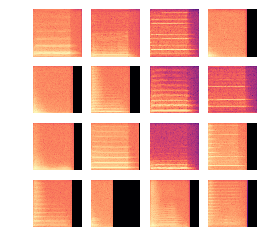

In [19]:
generate_images(source='real', save=False)

Finished epoch 2.05


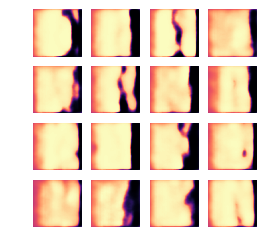

Time taken 371.2386808395386 sec


In [ ]:
# Can exit any time because model saves after every epoch
try:
    saver.restore(sess, "checkpoints/model")
except: 
    while True:
        ans = input("Saved checkpoint invalid, save new checkpoint? (y/n): ")
        if(ans == "y"):
            saver.save(sess, "checkpoints/model")
            break
        elif(ans != "n"):
            print("Invalid response, please type \"y\" or \"n\"")
        else:
            break

while True:
    try:
        runOneEpoch(batch, noise_dim, gen_opt, critic_opt, images, getEpoch, 
                    increment, ranEpoch, 0.05)
        saver.save(sess, "checkpoints/model")
    except:
        print("Error caught, restarting from checkpoint")
        saver.restore(sess, "checkpoints/model")

In [ ]:
print(sess.run(images).shape)

In [ ]:
testAudio(images, "real")
testAudio(generated, "fake")

In [ ]:
while(kernel is dead):
    plant_a_new_seed()